# Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random


## Load Data

In [2]:
import os
os.getcwd()


'/scratch/hpda/indycar/predictor/notebook/6.SectionRank'

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
event = 'Indy500'

inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
outputprefix = year +'-' + event + '-'
dataset = pd.read_csv(inputfile)
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18500 entries, 0 to 18499
Data columns (total 21 columns):
rank                    18500 non-null int64
car_number              18500 non-null int64
unique_id               18500 non-null object
completed_laps          18500 non-null int64
elapsed_time            18500 non-null float64
last_laptime            18500 non-null float64
lap_status              18500 non-null object
best_laptime            18500 non-null float64
best_lap                18500 non-null object
time_behind_leader      18500 non-null float64
laps_behind_leade       18500 non-null object
time_behind_prec        18500 non-null float64
laps_behind_prec        18500 non-null object
overall_rank            18500 non-null object
overall_best_laptime    18500 non-null float64
current_status          18500 non-null object
track_status            18500 non-null object
pit_stop_count          18500 non-null object
last_pitted_lap         18500 non-null object
start_position

### The Simulator

simple model without DNF

1. laptime, modeled by average lap time on green laps
2. pitstop, uniform distributed in pit window(10 laps)
3. pitime, modeled by inlap, outlap time


In [4]:
#green laps
alldata = dataset.copy()
carnos = np.sort(list(set(alldata.car_number.values)))
rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)

# since the flag changes in the middle of a lap, != 'Y' does not work here
#greendata = rankdata[rankdata['track_status']!='Y']
yellow_laps = rankdata[rankdata['track_status']=='Y'].completed_laps.values
green_laps = set(rankdata.completed_laps.values) - set(yellow_laps)
greendata = rankdata[rankdata['completed_laps'].isin(green_laps)]

# car_number, startpos, norm_lap, in_lap, out_lap
statdata = np.zeros((len(carnos), 8))
for idx, car in enumerate(carnos):
        thiscar = greendata[greendata['car_number']==car]
        
        pit_laps = thiscar[thiscar['lap_status']=='P'].completed_laps.values
        in_lap = thiscar[thiscar['completed_laps'].isin(pit_laps)].last_laptime.values
        out_laps = [x+1 for x in pit_laps]
        out_lap = thiscar[thiscar['completed_laps'].isin(out_laps)].last_laptime.values
        
        normal_laps = set(thiscar.completed_laps.values) - set(pit_laps) -set(out_laps)
        _laps = [x if x-1 in normal_laps else -1 for x in normal_laps]
        _laps=np.array(_laps)
        normal_laps = _laps[_laps>0]
        norm_lap = thiscar[thiscar['completed_laps'].isin(normal_laps)].last_laptime.values
        
        #save statistics
        statdata[idx, 0] = car
        startPos = thiscar[thiscar['completed_laps']==1].start_position.values[0]
        statdata[idx, 1] = int(startPos, 16)
        statdata[idx, 2] = np.mean(norm_lap)
        statdata[idx, 3] = np.std(norm_lap)
        statdata[idx, 4] = np.mean(in_lap)
        statdata[idx, 5] = np.std(in_lap)
        statdata[idx, 6] = np.mean(out_lap)
        statdata[idx, 7] = np.std(out_lap)
        
df = pd.DataFrame({'car_number':statdata[:,0].astype(int),'start_position':statdata[:,1].astype(int),'norm_lap_mean':statdata[:,2],'norm_lap_std':statdata[:,3],
                   'in_lap_mean':statdata[:,4],'in_lap_std':statdata[:,5],'out_lap_mean':statdata[:,6],'out_lap_std':statdata[:,7]})        
df.to_csv(outputprefix + 'simulator.csv')
simdf = df.copy()

In [5]:
df.head(10)

,car_number,in_lap_mean,in_lap_std,norm_lap_mean,norm_lap_std,out_lap_mean,out_lap_std,start_position
0,1,54.339015,8.424845e-01,41.743706,0.766367,66.104833,0.730250,4
1,3,54.281610,7.251726e-01,41.611673,0.676782,66.911113,0.401542,8
2,4,54.295602,3.190570e-01,41.946153,0.770234,68.036082,0.729633,11
3,6,64.027260,8.913270e-01,42.018802,0.778819,55.488440,0.238874,18
4,7,76.500685,5.074079e+00,43.346298,1.081907,58.039793,0.983255,28
5,9,54.458102,1.106836e+00,42.022496,0.701250,66.476525,0.545905,9
6,10,67.298100,1.421085e-14,42.409261,1.136934,55.727200,0.000000,29
7,12,53.857717,1.671692e+00,41.485985,0.776325,65.957933,0.901091,3
8,13,55.341700,7.105427e-15,41.927896,0.640302,67.616600,0.000000,7
9,14,55.449998,1.114515e+00,41.540961,0.629124,66.876700,0.556106,10


In [6]:
# pit window
# the first pit is more reasonable, the pit window should at least to be 7 laps
#
maxpitcnt = max([int(x,16) for x in rankdata.pit_stop_count.values])

for pit in range(1,maxpitcnt):
    pit_laps= np.sort(list(rankdata[(rankdata['pit_stop_count']==('%x'%(pit))) 
                                & (rankdata['lap_status']=='P')].completed_laps.values))
    print('%d:%d, %d'%(pit, min(pit_laps), max(pit_laps)))
    
    

1:29, 36
2:35, 70
3:52, 108
4:60, 141
5:96, 175
6:107, 197
7:120, 196
8:138, 195
9:180, 191


#### Simulator

In [7]:
def run_simulator(rankdata, simdf, savemodel=''):
    """
    input: simdf, rankdata
    
    simulator output the same data format as rankdata(C_xxx)
        #rank, car_number, completed_laps,elapsed_time,last_laptime
        #lap_status,track_status, pit_stop_count, last_pitted_lap
    """
    
    #init
    random.seed()

    maxlaps = max(set(rankdata.completed_laps.values))
    cols=['rank', 'car_number', 'completed_laps','elapsed_time','last_laptime',
          'lap_status','track_status', 'pit_stop_count', 'last_pitted_lap']
    colid={key:idx for idx, key in enumerate(cols)}

    # fixed pit strategy
    # max laps = 38
    # pit window = 8
    # uniform distribution in [last_pit+38-8, last_pit+38]
    pit_maxlaps = 38
    pit_window = 8
    carnos = np.sort(list(set(simdf.car_number.values)))
    #carnos = simdf.car_number.values
    carid = {key:idx for idx, key in enumerate(carnos)}

    data = np.zeros((len(carnos)*maxlaps, len(cols)))
    #print('maxlaps=%d, data shape=%s'%(maxlaps, data.shape))    
    
    # fixed pit strategy
    # max laps = 38
    # pit window = 8
    # uniform distribution in [last_pit+38-8, last_pit+38]
    for car in carnos:
        curlap = 0
        pit_cnt = 0
        while curlap < maxlaps:
            #set the next pit lap
            #uniform in [curlap + ]
            right = curlap + pit_maxlaps
            if right > maxlaps:
                # no need to pitstop
                break
            left = curlap + pit_maxlaps - pit_window
            pit_lap = int(random.uniform(left, right))
            #set it
            data[carid[car] * maxlaps + pit_lap, colid['lap_status']] = 1
            data[carid[car] * maxlaps + pit_lap, colid['pit_stop_count']] = pit_cnt
            data[carid[car] * maxlaps + pit_lap, colid['last_pitted_lap']] = pit_lap

            pit_cnt += 1
            curlap = pit_lap
            
    # simulate the lap time
    # startPenalty = startPosition * 0.11(s)

    for car in carnos:
        last_ispit = 0
        param = simdf[simdf['car_number']==car]
        elapsed_time = param.start_position * 0.11
        for lap in range(maxlaps):
            cur_ispit = data[carid[car] * maxlaps + lap, colid['lap_status']]
            if last_ispit:
                #use out_lap
                laptime = random.gauss(param['out_lap_mean'],param['out_lap_std'])
            elif cur_ispit:
                #use in_lap
                laptime = random.gauss(param['in_lap_mean'],param['in_lap_std'])
            else:
                #use norm_lap
                laptime = random.gauss(param['norm_lap_mean'],param['norm_lap_std'])

            data[carid[car] * maxlaps + lap, colid['last_laptime']] = laptime
            elapsed_time += laptime
            data[carid[car] * maxlaps + lap, colid['elapsed_time']] = elapsed_time

            data[carid[car] * maxlaps + lap, colid['car_number']] = car
            #start from lap 1
            data[carid[car] * maxlaps + lap, colid['completed_laps']] = lap + 1

            #update and goto next lap
            last_ispit = cur_ispit

    # update the rank
    # carnumber = len(carnos)
    for lap in range(maxlaps):
        elapsed_time = [data[carid[car] * maxlaps + lap, colid['elapsed_time']] for car in carnos]
        indice = np.argsort(elapsed_time)
        rank = np.arange(len(carnos))
        out = np.arange(len(carnos))
        out[indice] = rank + 1
        for car in carnos:
            data[carid[car] * maxlaps + lap, colid['rank']] = int(out[carid[car]])

    #save data
    #rank, car_number, completed_laps,elapsed_time,last_laptime
    #lap_status,track_status, pit_stop_count, last_pitted_lap
    df = pd.DataFrame({'rank': data[:, 0].astype(int), 'car_number': data[:, 1].astype(int),
                       'completed_laps': data[:, 2].astype(int),
                       'elapsed_time': data[:, 3], 'last_laptime': data[:, 4], 
                       'lap_status': [ 'P' if x==1 else 'T' for x in data[:, 5]],
                       'track_status': [ 'G' for x in data[:, 6]],
                       'pit_stop_count': data[:, 7], 'last_pitted_lap': data[:, 8]})
    if savemodel:
        df.to_csv(savemodel)
    
    return df

In [8]:
df = run_simulator(rankdata, simdf, outputprefix + 'simulator_completedlaps.csv')

In [9]:
df[df['completed_laps']==200]

,car_number,completed_laps,elapsed_time,lap_status,last_laptime,last_pitted_lap,pit_stop_count,rank,track_status
199,1,200,8524.414904,T,41.495909,0.0,0.0,6,G
399,3,200,8509.880001,T,41.177083,0.0,0.0,5,G
599,4,200,8584.906866,T,41.772368,0.0,0.0,14,G
799,6,200,8589.952493,T,41.979388,0.0,0.0,17,G
999,7,200,8915.303428,T,42.539478,0.0,0.0,33,G
1199,9,200,8581.665014,T,41.233982,0.0,0.0,13,G
1399,10,200,8691.470883,T,42.892826,0.0,0.0,26,G
1599,12,200,8486.497789,T,42.274900,0.0,0.0,1,G
1799,13,200,8592.326750,T,42.546704,0.0,0.0,19,G
1999,14,200,8505.558237,T,42.841117,0.0,0.0,4,G


### run simulation

In [10]:
runs=100
maxlaps = max(set(rankdata.completed_laps.values))
carnos = np.sort(list(set(simdf.car_number.values)))
carid = {key:idx for idx, key in enumerate(carnos)}

#laps = [100,200]
laps = range(1,201)
#contigency matrix
#<lap, carno, rankCnt>
cmat = np.zeros((len(laps), len(carnos), len(carnos)))

for run in range(runs):
    df = run_simulator(rankdata, simdf)
    #save rank@lap100 and rank@lap200
    for idx, lap in enumerate(laps):
        data = df[df['completed_laps']==lap][['car_number','rank']].to_numpy()
        for pt in data:
            cmat[idx, carid[pt[0]], pt[1]-1] += 1
    
print('simulation finished!')


simulation finished!


In [14]:
#save the simulation result
retfile = outputprefix + 'simulator-run%d.dat'%runs
cmatsave = cmat.reshape((-1, len(carnos)*len(carnos)))
np.savetxt(retfile, cmatsave)

### check the result

In [12]:
#check the result
laps = [1,15,32,50,150,200]
#check rank 1@lap100, @lap200
for lap in laps:
    print('rank1@lap',lap, ':', cmat[lap-1,:,0])
    
#print('rank1@lap200:',cmat[1,:,0])

('rank1@lap', 1, ':', array([ 8.,  4.,  1.,  0.,  0.,  0.,  0., 26.,  1.,  1.,  0.,  0.,  5.,
        0., 27.,  5., 21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.]))
('rank1@lap', 15, ':', array([ 4.,  9.,  0.,  0.,  0.,  0.,  0., 31.,  0., 13.,  0.,  0.,  1.,
        0., 24.,  1., 15.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.]))
('rank1@lap', 32, ':', array([ 2.,  5.,  0.,  0.,  0.,  0.,  0., 29.,  0., 24.,  0.,  0.,  0.,
        0., 19.,  1., 17.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.]))
('rank1@lap', 50, ':', array([ 0.,  4.,  0.,  0.,  0.,  0.,  0., 53.,  0., 13.,  0.,  0.,  0.,
        0., 21.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.]))
('rank1@lap', 150, ':', array([ 0.,  2.,  0.,  0.,  0.,  0.,  0., 80.,  0.,  5.,  0.,  0.,  0.,
        0.,  7.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

#### check the result of will power

In [15]:
cmat[:,7,0]

array([26., 24., 19., 18., 22., 19., 19., 22., 27., 33., 33., 30., 29.,
       32., 31., 30., 36., 33., 33., 32., 35., 35., 38., 38., 37., 39.,
       38., 37., 39., 41., 34., 29., 28., 26., 24., 17., 16., 27., 53.,
       52., 50., 47., 51., 49., 48., 46., 49., 53., 53., 53., 52., 52.,
       55., 54., 56., 54., 53., 52., 52., 56., 51., 49., 46., 44., 44.,
       44., 37., 30., 21., 19., 17., 25., 32., 49., 56., 56., 57., 59.,
       57., 56., 62., 62., 61., 63., 61., 60., 62., 62., 64., 63., 67.,
       66., 64., 58., 58., 56., 50., 55., 47., 47., 45., 38., 29., 30.,
       32., 41., 49., 56., 58., 65., 68., 68., 68., 70., 71., 74., 72.,
       75., 74., 73., 73., 75., 73., 72., 72., 71., 74., 71., 66., 65.,
       62., 64., 51., 46., 41., 37., 32., 29., 34., 44., 53., 66., 70.,
       76., 77., 81., 81., 78., 79., 80., 81., 82., 81., 83., 82., 84.,
       83., 84., 81., 79., 79., 76., 74., 73., 68., 58., 53., 51., 46.,
       39., 39., 45., 44., 49., 57., 64., 70., 75., 80., 82., 84

In [20]:
leader = rankdata[rankdata['rank']==1]
willpower_in_lead = leader[leader['car_number']==12].completed_laps.values
willpower_pred_lead = cmat[:,7,0]
willpower_in_lead

array([ 92,  93,  94, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 196, 197, 198, 199, 200])

In [25]:
willpower_in_lead.astype(int)-1

array([ 91,  92,  93, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 195, 196, 197, 198, 199])

In [26]:
willpower_pred_lead[willpower_in_lead.astype(int)-1]

array([66., 64., 58., 56., 58., 65., 68., 68., 68., 70., 71., 74., 72.,
       75., 74., 73., 73., 75., 73., 72., 72., 71., 74., 71., 53., 66.,
       70., 76., 77., 81., 81., 78., 79., 80., 81., 82., 81., 83., 82.,
       84., 83., 84., 81., 79., 79., 76., 74., 73., 68., 58., 53., 51.,
       46., 39., 76., 76., 76., 72., 72.])

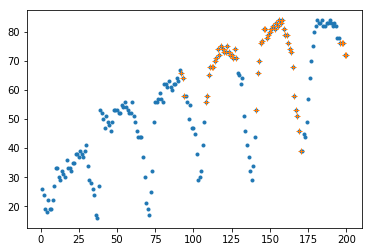

In [30]:
laps = range(1,201)
plt.plot(laps, willpower_pred_lead,'.')
plt.plot(willpower_in_lead, willpower_pred_lead[willpower_in_lead.astype(int)-1],'+')
plt.show()

#### performance of the simulator prediction over the groundtruth

In [ ]:
# train on first 80 simulation and test on the latest 20
laps = range(1,201)


#### performance of the simulator prediction over the realrace truth

In [41]:
#model preidction
laps = range(1,201)
simulator_pred = []
for lap in laps:
    simulator_pred.append(np.argmax(cmat[lap-1,:,0]))
    
simulator_pred = np.array(simulator_pred)

In [42]:
ground_truth = []
for car in leader.car_number.values:
    ground_truth.append(carid[car] )
len(ground_truth)
ground_truth = np.array(ground_truth)

In [59]:
idx = ((simulator_pred - ground_truth[1:]) == 0)
print(np.mean(idx), np.mean(idx[100:]),np.mean(idx[:50]),np.mean(idx[:100]),np.mean(idx[:150]))

(0.325, 0.56, 0.12, 0.09, 0.26666666666666666)


In [52]:
# very low accuracy
idx = (simulator_pred - ground_truth[1:]) == 0
simulator_pred[idx]


array([14, 14, 14, 14, 14, 14,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7])

### conclusion

even such a simple simulator demonstrates the uncertainty of the long term rank distribution.